# Transportation Access Classifier

Welcome to this project where we build an efficient **image classifier** using **TensorFlow** and the **MobileNetV2** architecture.

MobileNetV2 is a lightweight deep neural network designed for mobile and embedded vision applications. It balances **accuracy** and **speed**, making it a great choice for image classification tasks.

### 🛠️ Project Overview
- **Model:** MobileNetV2 (pre-trained on ImageNet)
- **Task:** Classify images into multiple categories
- **Data:** Custom dataset organized into train/validation folders( the links to the dataset is mentioned below)
- **Frameworks:** TensorFlow, Keras
- **Hardware:** CPU (no GPU)

---

### 📋 Steps Covered
1. Data Preparation and Augmentation
2. Model Building and Customization
3. Model Training and Saving
4. Model Evaluation
5. Visualization of Training History

---

### 🎯 Objectives
- Leverage transfer learning to speed up training
- Achieve high classification accuracy
- Save the trained model for future use
- Visualize performance with loss and accuracy graphs

---

The links to the datasets: https://www.kaggle.com/datasets/kshitij192/cars-image-dataset , https://universe.roboflow.com/kicksquad/scooter-only, https://www.kaggle.com/datasets/mmohaiminulislam/vehicles-image-dataset

The link to the research paper of the model we used: https://arxiv.org/abs/1801.04381



## First Step 
### Importing the important libraries and Data preparation

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='PIL.Image')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [9]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.0001


In [13]:
train_dir = 'dataset/train'
validation_dir = 'dataset/val'
test_dir = 'dataset/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',  
    classes=None,  
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb', 
    classes=None,  
    shuffle=False
)



test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)



Found 2100 images belonging to 3 classes.
Found 450 images belonging to 3 classes.
Found 450 images belonging to 3 classes.


In [14]:
num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")
print(f"Class indices: {train_generator.class_indices}")


Number of classes: 3
Class indices: {'car': 0, 'denied': 1, 'scooter': 2}


## Second Step 
### Model Building and  Customization

In [15]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = True
for layer in base_model.layers[:-4]:  
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

2025-04-26 21:16:44.119475: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,572,803 (13.63 MB)

 Trainable params: 1,727,619 (6.59 MB)

 Non-trainable params: 1,845,184 (7.04 MB)

## Third Step 
### Model Training and Saving

In [16]:
history = model.fit(
    train_generator,
     epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    verbose=1
)

model.save('mobilenet_transport_access_classifier.keras')
print("Model saved as mobilenet_transport_access_classifier.keras")

/home/roba/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 50s 718ms/step - accuracy: 0.7968 - loss: 0.4982 - val_accuracy: 0.9040 - val_loss: 0.2507
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 46s 687ms/step - accuracy: 0.9432 - loss: 0.1531 - val_accuracy: 0.9464 - val_loss: 0.1676
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 44s 669ms/step - accuracy: 0.9469 - loss: 0.1215 - val_accuracy: 0.9420 - val_loss: 0.1684
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 44s 673ms/step - accuracy: 0.9736 - loss: 0.0731 - val_accuracy: 0.9330 - val_loss: 0.1884
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 44s 666ms/step - accuracy: 0.9675 - loss: 0.0904 - val_accuracy: 0.9353 - val_loss: 0.1982
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 44s 660ms/step - accuracy: 0.9814 - loss: 0.0587 - val_accuracy: 0.9375 - val_loss: 0.1836
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 44s 665ms/step - accuracy: 0.9768 - loss: 0.0564 - val_accuracy: 0.9442 - val_loss: 0.1707
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 44s 663ms/step - accuracy: 0.9882 - loss: 0.0417 - val_accu

## Fourth Step
### Model Evaluation on Test Data

In [17]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy}")
print(f"Test loss: {test_loss}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 460ms/step - accuracy: 0.9759 - loss: 0.0522
Test accuracy: 0.9688888788223267
Test loss: 0.06611640006303787


## Fifth Step
### Visualizing the Training History

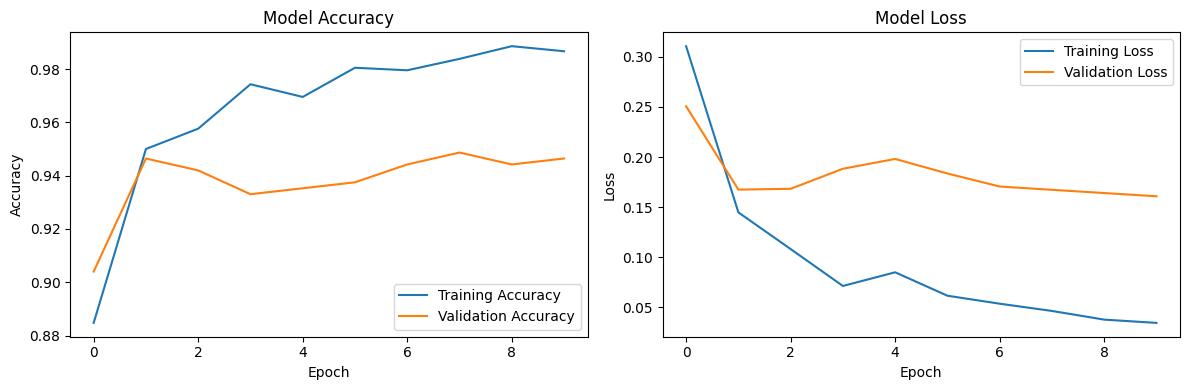

Training history plot saved as 'training_history.png'


In [20]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()
plt.close()
print("Training history plot saved as 'training_history.png'")
